In [ ]:
import pandas as pd
import numpy as np
import torch
!pip install fastai==0.7.0
!pip install torchtext==0.2.3

import fastai
from fastai.imports import *
from fastai.torch_imports import *
from fastai.core import *
from fastai.model import fit
from fastai.dataset import *

from sklearn.svm import LinearSVC

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *
from fastai.text import *
from sklearn import svm

import dill as pickle
!pip install spacy
!python -m spacy download en
import spacy
import html

import pickle
import collections
import math
!pip install nbimporter
import nbimporter

In [ ]:
## DATA CLEANING AND TOKENIZATION
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# define paths and load data
clas_path = Path('clas')
lm_path   = Path('lm')
my_data   = pd.read_csv('datasets/gop_debate.csv')

y = my_data.sentiment
x = my_data.text

## classification
# create training and validation sets
trn_texts,val_texts, trn_labels, val_labels = sklearn.model_selection.train_test_split(
                                              x, y, test_size = 0.2,
                                              random_state = 41)

trn_texts  = np.array(trn_texts)
trn_labels = np.array(trn_labels)
val_texts  = np.array(val_texts)
val_labels = np.array(val_labels)


# randomize order
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))


# reorder texts
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]


# reorder labels 
trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]


# create dataframe
col_names = ['labels','text']
df_trn    = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns = col_names)
df_val    = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns = col_names)


# save training and validation dataset
classes = ['Positive', 'Negative', 'Neutral']
df_trn.to_csv(clas_path/'train.csv', header = False, index = False)
df_val.to_csv(clas_path/'test.csv', header = False, index = False)
(clas_path/'classes.txt').open('w').writelines(f'{o}\n' for o in classes)


## language model
# create training and validation sets
trn_texts, val_texts = sklearn.model_selection.train_test_split(
                     np.concatenate([trn_texts,val_texts]), test_size = 0.1,
                     random_state = 43)


# saving training and validation dataset
df_trn = pd.DataFrame({'text':trn_texts, 'labels':
                       [0]*len(trn_texts)}, columns = col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':
                       [0]*len(val_texts)}, columns = col_names)

df_trn.to_csv(lm_path/'train.csv', header = False, index = False)
df_val.to_csv(lm_path/'test.csv', header = False, index = False)

In [ ]:
from functions import Prep

# tokenization
chunksize = 5000
BOS       = 'xbos'  # beginning-of-sentence tag
df_trn    = pd.read_csv(lm_path/'train.csv', header = None, chunksize = chunksize)
df_val    = pd.read_csv(lm_path/'test.csv', header = None, chunksize = chunksize)

tok_trn, trn_labels = Prep.get_all(df_trn, 1)
tok_val, val_labels = Prep.get_all(df_val, 1)

# save tokenization
np.save(lm_path/'tok_trn.npy', tok_trn)
np.save(lm_path/'tok_val.npy', tok_val)

In [4]:
# limit vocabulary
max_vocab = 60000
min_freq  = 2

freq = Counter(p for o in tok_trn for p in o)


# create translation from integer to string and string to integer
itos = [o for o,c in freq.most_common(max_vocab) if c > min_freq]
itos.insert(0, '_unk_')
itos.insert(1, '_pad_')

stoi = collections.defaultdict(lambda:0, 
                               {v:k for k,v in enumerate(itos)})


# tweets expressed as integers
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])


# save dictionary
np.save(lm_path/'trn_ids.npy', trn_lm)
np.save(lm_path/'val_ids.npy', val_lm)
pickle.dump(itos, open(lm_path/'itos.pkl', 'wb'))

In [5]:
## PRETRAINED LANGUAGE MODEL


# set model parameters
em_sz, nh, nl = 400, 1150, 3


# load itos and stoi from the pretrained Wikitext language model
with open('wt103/itos_wt103.pkl', 'rb') as pickle_file:
    itos_wiki = pickle.load(pickle_file)
    
stoi_wiki = collections.defaultdict(lambda: -1, {v:k for k,v 
                                              in enumerate(itos_wiki)})

lm_wgts_wiki = torch.load('wt103/fwd_wt103.h5', map_location = lambda storage, 
                  loc: storage)




In [11]:
wd   = 1e-7
bptt = 70
bs   = 4
t    = len(np.concatenate(trn_lm))


# define optimizer and create data loader 
opt_fn  = partial(optim.Adam, betas = (0.8, 0.99))
trn_dl  = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl  = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)

# match tokens between the two vocabularies
enc_wgts = lm_wgts_wiki['0.encoder.weight'].numpy()
row_m    = np.mean(enc_wgts, axis = 0)

new_wm = np.zeros((len(itos), em_sz), dtype = np.float32)
for i,w in enumerate(itos):
    r  = stoi_wiki[w]
    new_wm[i] = enc_wgts[r] if r >= 0 else row_m
    
lm_wgts_wiki['0.encoder.weight']                    = T(new_wm)
lm_wgts_wiki['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_wm))
lm_wgts_wiki['1.decoder.weight']                    = T(np.copy(new_wm))

RuntimeError: cuda runtime error (30) : unknown error at C:\Anaconda2\conda-bld\pytorch_1519496000060\work\torch\lib\THC\THCGeneral.c:120

In [9]:
## CREATE MODEL ARCHITECTURE


md = LanguageModelData('', pad_idx = 1, n_tok = len(itos), trn_dl = trn_dl, val_dl = val_dl, bs = bs, 
                       bptt = bptt)

# define droupout parameters and create model architecture
drops   = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7
learner = md.get_model(opt_fn, em_sz, nh, nl, 
          dropouti = drops[0], dropout = drops[1], wdrop = drops[2],
          dropoute = drops[3], dropouth = drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

NameError: name 'trn_dl' is not defined

In [8]:
# load model weights from pretrained wikipedia model
learner.model.load_state_dict(lm_wgts_wiki)


# set initial learning rate
lr  = 1e-3


# fit model with frozen lstm for one epoch
learner.fit(lr, 1, wds = wd, use_clr = (32,2), cycle_len = 3) 

epoch      trn_loss   val_loss   accuracy                                                                              
    0      6.586737   6.163485   0.139035  
    1      5.930291   5.278863   0.207233                                                                              
    2      5.439476   5.015949   0.234874                                                                              



[array([5.01595]), 0.2348736673593521]

 89%|██████████████████████████████████████████████████████████████▉        | 55/62 [00:26<00:03,  2.06it/s, loss=22.4]

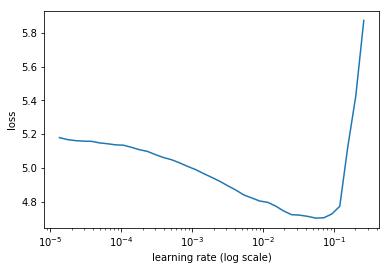

In [9]:
# save learner for further training
learner.save('lm_last_ft')


# unfreeze all layers
learner.unfreeze()


# perform and plot algorithm to find optimal learning rate
learner.lr_find(lr/1000)
learner.sched.plot()

In [10]:
learner.load('lm_last_ft')


# set discriminative learning rate
lr  = 1e-2
lrm = 2.6
lrs = np.array([lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])


# fit model with unfrozen lstm layers until it overfits
learner.fit(lrs, 1, wds = wd, use_clr = (20,10), cycle_len = 3)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      3.5965     2.912739   0.484899  
    1      3.024697   2.706622   0.515156                                                                              
    2      2.700665   2.624533   0.530128                                                                              


[array([2.62453]), 0.530128408481579]

In [11]:
# save complete model and encoder
learner.save('lm2')
learner.save_encoder('lm2_enc')

In [12]:
## DATA PREPARATION FOR CLASSIFIER

# tokenize saved training and validation datasets
df_trn = pd.read_csv(clas_path/'train.csv', header = None, chunksize = chunksize)
df_val = pd.read_csv(clas_path/'test.csv', header = None, chunksize = chunksize)

tok_trn, trn_labels = Prep.get_all(df_trn, 1)
tok_val, val_labels = Prep.get_all(df_val, 1)


(clas_path/'tmp').mkdir(exist_ok = True)
np.save(clas_path/'tmp'/'tok_trn.npy', tok_trn)
np.save(clas_path/'tmp'/'tok_val.npy', tok_val)
np.save(clas_path/'tmp'/'trn_labels.npy', trn_labels)
np.save(clas_path/'tmp'/'val_labels.npy', val_labels)
tok_trn = np.load(clas_path/'tmp'/'tok_trn.npy')
tok_val = np.load(clas_path/'tmp'/'tok_val.npy')

0
1
2
0


In [13]:
# load vocabulary from language model
itos = pickle.load((lm_path/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in 
                                          enumerate(itos)})

In [14]:
# encode tokens
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])
np.save(clas_path/'tmp'/'trn_ids.npy', trn_clas)
np.save(clas_path/'tmp'/'val_ids.npy', val_clas)

In [15]:
trn_clas   = np.load(clas_path/'tmp'/'trn_ids.npy')
val_clas   = np.load(clas_path/'tmp'/'val_ids.npy')
trn_labels = np.load(clas_path/'tmp'/'trn_labels.npy')
val_labels = np.load(clas_path/'tmp'/'val_labels.npy')

In [16]:
# set hyperparameters
bptt, nh   = 70, 1150  # number of hidden activations per layer 
 
em_sz, nl  = 400,3 # size of each embedding vector, number of layers

bs, c      = 64, 3
vs         = len(itos)

opt_fn = partial(optim.Adam, betas = (0.8, 0.99))

In [17]:
## CREATE MODEL ARCHITECTURE

import functions as fct

# function using sampler and data loader from fastai library
md = fct.data_loader('', trn_clas, val_clas, trn_labels, val_labels, bs = bs, pad_idx = 1)


# define droupout parameters and create model architecture
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.4])*0.7
m   = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz = em_sz, n_hid = nh, 
                        n_layers = nl, pad_token = 1,
                        layers   = [em_sz*3, 50, c], drops = [dps[4], 0.1],
                        dropouti = dps[0], wdrop = dps[1],        
                        dropoute = dps[2], dropouth = dps[3])

In [18]:
# building classifier model
learn         = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn = opt_fn)
learn.reg_fn  = partial(seq2seq_reg, alpha = 2, beta = 1)
learn.clip    = .25

#ACC = sum(p_val==test_labels,1)/length(test_labels)
learn.metrics = [accuracy]

In [19]:
# set discriminative learning rate
lr  = 3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [20]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [21]:
# set weight decay and load encoder from language model
wd = 1e-7
wd = 0
learn.load_encoder('lm2_enc')

 89%|█████████████████████████████████████████████████████████████▍       | 155/174 [00:11<00:01, 12.87it/s, loss=4.43]

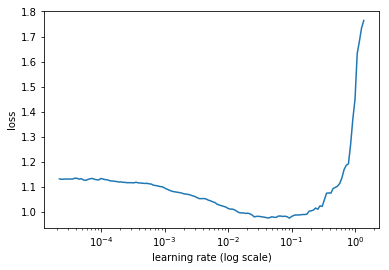

 89%|█████████████████████████████████████████████████████████████▍       | 155/174 [00:30<00:01, 12.87it/s, loss=4.43]

In [22]:
# freeze lstms and relu layer
learn.freeze_to(-1)


# perform and plot algorithm to find optimal learning rate
learn.lr_find(lrs/1000)
learn.sched.plot()

In [23]:
# readjust discriminative learning rate if necessary
lr  = 3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [24]:
learn.save('clas_0')
learn.load('clas_0')
learn.freeze_to(-2)

In [25]:
# fit frozen model for one epoch
learn.fit(lrs, 1, wds = wd, cycle_len = 1, use_clr = (8,3))


epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.864027   0.749293   0.696453  


[array([0.74929]), 0.6964534729283031]

In [26]:
learn.save('clas_0')
learn.load('clas_0')


# unfreeze relu layer and fit another epoch
learn.freeze_to(-2)
learn.fit(lrs, 1, wds = wd, cycle_len = 1, use_clr = (8,3))

learn.save('clas_1')

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.81292    0.717774   0.705863  


Accuracy = 95.7838% (2658/2775) (classification)


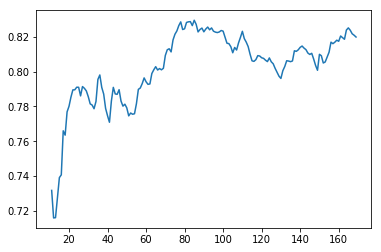

In [27]:
learn.load('clas_1')


# unfreeze all layers and execute final fit
learn.unfreeze()
#learn.fit(lrs, 1, wds = wd, cycle_len = 2, use_clr = (32,10))

import os
os.chdir(r'C:\Users\lenovo\Anaconda3\fastai\SIS_ULMFiT-master\libsvm-3.23\python')
from svm import *
from svmutil import *

from svm import __all__ as svm_all
from svm import scipy, sparse

prob = svm_problem( val_labels, val_clas)
param = svm_parameter('-t 2 -c  5.6569 -g 1.0667 -b 1') 
model = svm_train(prob, param) 
p_label, p_acc, p_val = svm_predict(val_labels, val_clas,model,'-b 1')
ACC, MSE, SCC = evaluations(val_labels, p_label)
#ACC = sum(p_val==test_labels,1)/length(test_labels)
#learn.metrics = [accuracy]


learn.sched.plot_loss()
#learn.save('clas_2')

AttributeError: 'float' object has no attribute 'p_label'

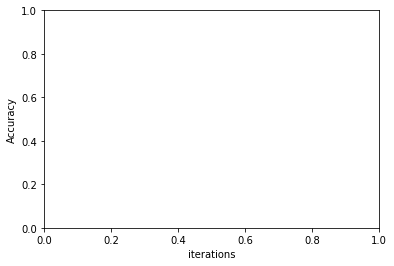

In [29]:
   def plot_Acc(self):
        plt.xlabel("iterations")
        plt.ylabel("Accuracy")
        plt.plot(self.p_label, self.ACC)

plot_Acc(ACC)